In [1]:
## Imports
import os
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.metrics import precision_recall_curve
import optuna
from optuna.integration import CatBoostPruningCallback

/Users/thomas/Vault/01 Development/University/p2p-credit-risk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = 'ml/NoTransformations'
X_train = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))['is_default']
X_val   = pd.read_csv(os.path.join(data_dir, 'X_val.csv'))
y_val   = pd.read_csv(os.path.join(data_dir, 'y_val.csv'))['is_default']
X_test  = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))
y_test  = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))['is_default']

In [3]:
# Defining categorical columns
cat_cols = [
    'Gender',
    'Education',
    'EmploymentDurationCurrentEmployer',
    'VerificationType',
    'ApplicationSignedWeekday',
    'ApplicationSignedHour',
    'MonthlyPaymentDay'
]

# Convert categorical columns to string type
for df in (X_train, X_val, X_test):
    df[cat_cols] = df[cat_cols].astype(str)

In [4]:
# Define the pools for training and validation
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_cols)

In [5]:
def objective(trial: optuna.Trial) -> float:
    """Define the objective function for Optuna to maximize."""
    
    # Suggest hyperparameters for the trial
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_seed': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Initialize the model with trial parameters
    model_trial = CatBoostClassifier(**params)
    
    # Train the model with early stopping to speed up the process - The Pruning Callback will stop unpromising trials early
    model_trial.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=50,
        callbacks=[CatBoostPruningCallback(trial, 'AUC')]
    )
    
    # Return the AUC on the validation set, which Optuna will maximize
    return model_trial.get_best_score()['validation']['AUC']

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=30)

# Train the Final Model using the Best Hyperparameters
print(f"Best validation AUC: {study.best_value:.4f}")
print("Best hyperparameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Get the best parameters and set the fixed ones for the final training run
best_params = study.best_params
best_params.update({
    'iterations': 1000,
    'eval_metric': 'AUC',
    'random_seed': 0,
    'early_stopping_rounds': 50,
    'verbose': 100,
})

# Instantiate and train the final, optimized model
model = CatBoostClassifier(**best_params)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

[I 2025-06-21 11:34:03,826] A new study created in memory with name: no-name-b307b5f2-82b8-4a79-b87c-e08dfcb9b3c9
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_23304/2215218028.py:26: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks=[CatBoostPruningCallback(trial, 'AUC')]
[I 2025-06-21 11:34:39,908] Trial 0 finished with value: 0.6942880667829999 and parameters: {'learning_rate': 0.04546478274347465, 'depth': 9, 'subsample': 0.7758737763888546, 'l2_leaf_reg': 1.457326545695477, 'colsample_bylevel': 0.6688704698007897, 'min_data_in_leaf': 95}. Best is trial 0 with value: 0.6942880667829999.
[I 2025-06-21 11:35:11,632] Trial 1 finished with value: 0.6924478105244634 and parameters: {'learning_rate': 0.01933989219437859, 'depth': 8, 'subsample': 0.7771895827531525, 'l2_leaf_reg': 6.769040471686157, 'colsample_bylevel': 0.8347013607401137, 'min_data_in_leaf': 42}. Best is trial 0 with valu

Best validation AUC: 0.6973
Best hyperparameters found:
  learning_rate: 0.04792571260379266
  depth: 8
  subsample: 0.9755715497224045
  l2_leaf_reg: 2.9300512363317237
  colsample_bylevel: 0.5932279489329734
  min_data_in_leaf: 1
0:	test: 0.6492678	best: 0.6492678 (0)	total: 29.2ms	remaining: 29.2s
100:	test: 0.6785404	best: 0.6785404 (100)	total: 3.01s	remaining: 26.8s
200:	test: 0.6840663	best: 0.6840663 (200)	total: 5.84s	remaining: 23.2s
300:	test: 0.6884045	best: 0.6884045 (300)	total: 8.93s	remaining: 20.7s
400:	test: 0.6904042	best: 0.6904042 (400)	total: 12.1s	remaining: 18s
500:	test: 0.6927786	best: 0.6927786 (500)	total: 15.1s	remaining: 15.1s
600:	test: 0.6946017	best: 0.6946458 (598)	total: 18.4s	remaining: 12.2s
700:	test: 0.6953979	best: 0.6954049 (699)	total: 21.6s	remaining: 9.23s
800:	test: 0.6966521	best: 0.6968248 (780)	total: 25s	remaining: 6.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6972546328
bestIteration = 840

Shrink model to fi

In [6]:
# Validation metrics
val_preds      = model.predict(X_val)
val_pred_probs = model.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_pred_probs))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Test metrics
test_preds      = model.predict(X_test)
test_pred_probs = model.predict_proba(X_test)[:, 1]
print("Test AUC:", roc_auc_score(y_test, test_pred_probs))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

Validation AUC: 0.6972546328234764
Validation Accuracy: 0.6701004510045101
              precision    recall  f1-score   support

       False       0.68      0.38      0.49      8094
        True       0.67      0.88      0.76     11418

    accuracy                           0.67     19512
   macro avg       0.67      0.63      0.62     19512
weighted avg       0.67      0.67      0.65     19512

Confusion Matrix:
 [[3082 5012]
 [1425 9993]]
Test AUC: 0.687721598655078
Test Accuracy: 0.6293240403833342
              precision    recall  f1-score   support

       False       0.68      0.36      0.47      8990
        True       0.61      0.86      0.71     10523

    accuracy                           0.63     19513
   macro avg       0.65      0.61      0.59     19513
weighted avg       0.65      0.63      0.60     19513

Test Confusion Matrix:
 [[3259 5731]
 [1502 9021]]


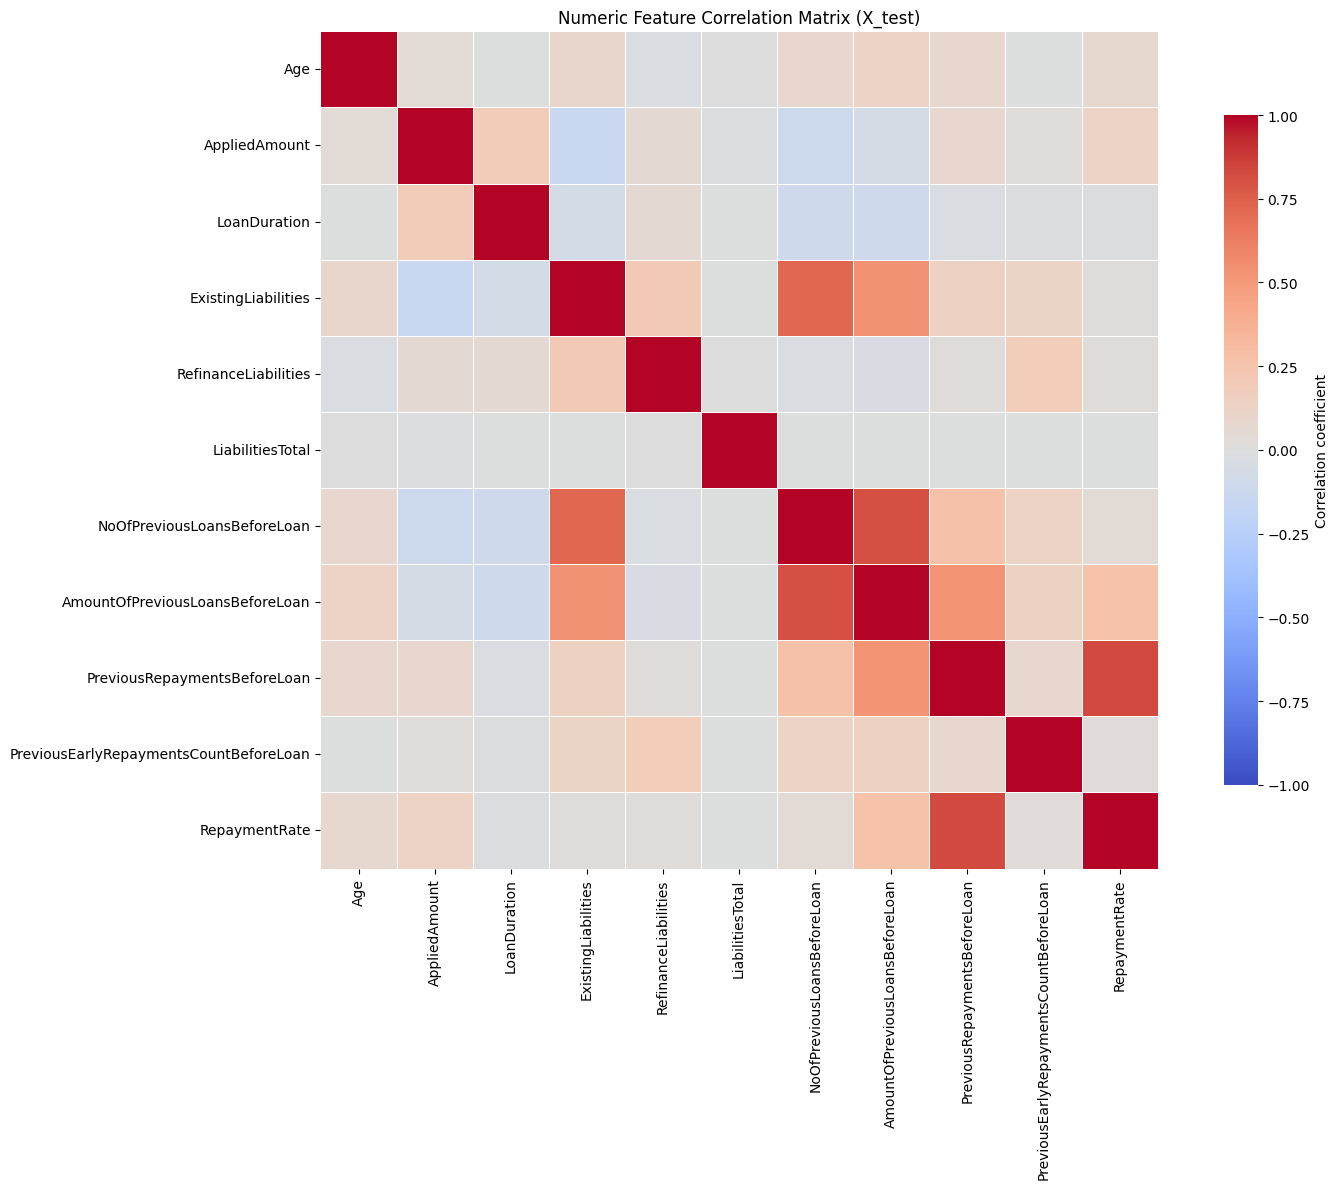

In [7]:
num_cols     = X_test.select_dtypes(include=[np.number]).columns
corr_matrix  = X_test[num_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=.5,
    cbar_kws={"label": "Correlation coefficient", "shrink": .8}
)
plt.title("Numeric Feature Correlation Matrix (X_test)")
plt.tight_layout()
plt.show()

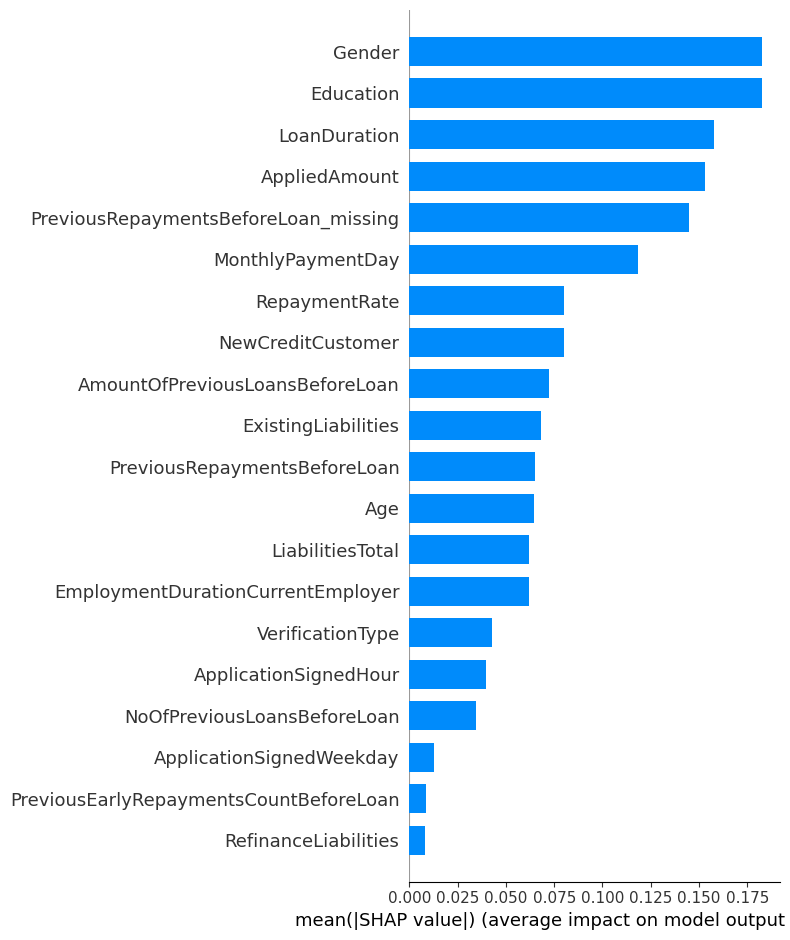

In [8]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

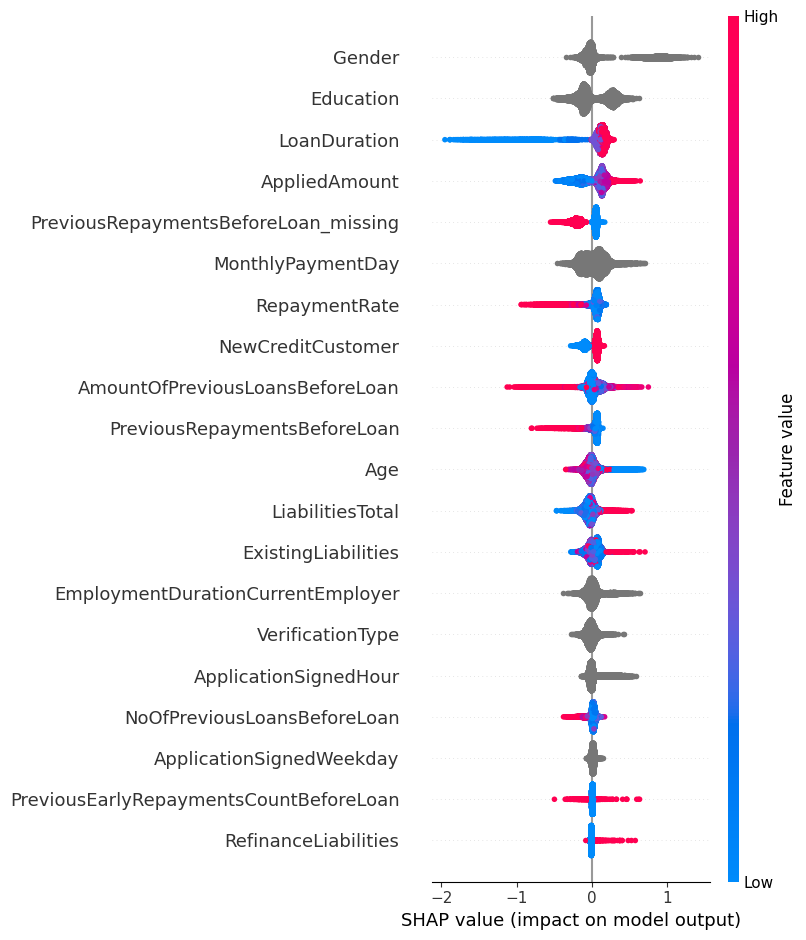

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [10]:
# Calculate the average absolute SHAP value for each feature on the test set
avg_shap_values = np.abs(shap_values).mean(axis=0)
avg_shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'avg_abs_shap': avg_shap_values
}).sort_values('avg_abs_shap', ascending=False)

print(avg_shap_df)

                                           feature  avg_abs_shap
1                                           Gender      0.196856
2                                        Education      0.186886
6                                     LoanDuration      0.173593
5                                    AppliedAmount      0.156445
18            PreviousRepaymentsBeforeLoan_missing      0.129516
10                               MonthlyPaymentDay      0.115176
22                                   RepaymentRate      0.089318
4                                NewCreditCustomer      0.081428
15                 AmountOfPreviousLoansBeforeLoan      0.080711
16                    PreviousRepaymentsBeforeLoan      0.069311
0                                              Age      0.068789
13                                LiabilitiesTotal      0.062955
11                             ExistingLiabilities      0.059989
3                EmploymentDurationCurrentEmployer      0.059443
7                        

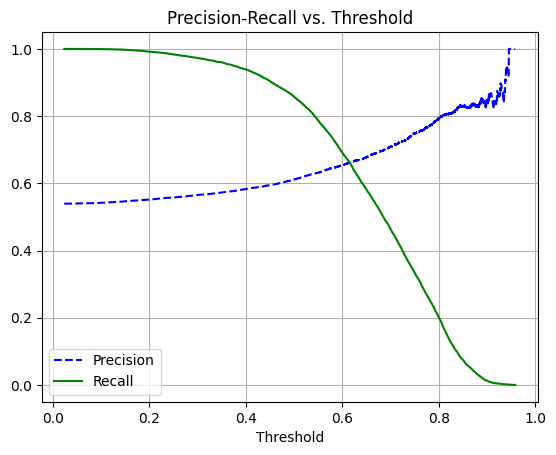

In [11]:
# Get probabilities for the positive class
test_pred_probs = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, test_pred_probs)

plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision-Recall vs. Threshold")
plt.grid(True)
plt.show()

To increase Recall (catch more defaults), we must decrease threshold. This means being less strict. The consequence is that we also flag more good loans as bad, so Precision goes down.

To increase Precision (be more certain that your flagged loans are actually bad), we must increase our threshold. This means being more strict. The consequence is that we miss more of the borderline-bad loans, so Recall goes down.

- Business Goal: "We are a new platform. We need to approve as many loans as possible to grow our user base. We are willing to accept a bit more risk to avoid turning away good customers."
- Business Goal: "The economy is uncertain. Our top priority is protecting our investors' capital. We must avoid defaults at all costs, even if it means rejecting some potentially good loans."
- Business Goal: "We want a good balance between managing risk and growing our loan book."